In [84]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras

In [85]:
print('tf version: {}'.format(tf.version.VERSION))
print('keras version: {}'.format(keras.__version__))

tf version: 2.0.0
keras version: 2.3.1


Multiple code snippets in this notebook are sourced and adapted from https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/

### EDA of files with different emotions


In [2]:
neutral_file = 'data/OAF_back_neutral.wav'
happy_file = 'data/OAF_back_happy.wav'
sad_file = 'data/OAF_back_sad.wav'

In [3]:
ipd.Audio(neutral_file)

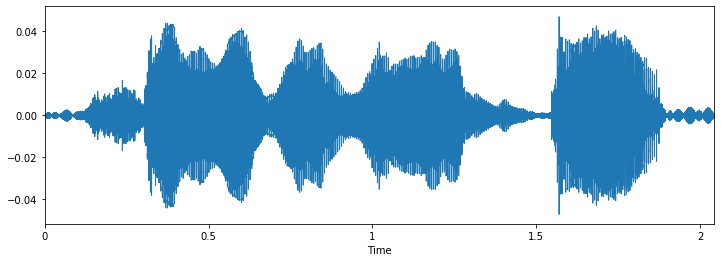

In [4]:
data_n, sampling_rate_n = librosa.load(neutral_file)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data_n, sr=sampling_rate_n)

In [5]:
ipd.Audio(sad_file)

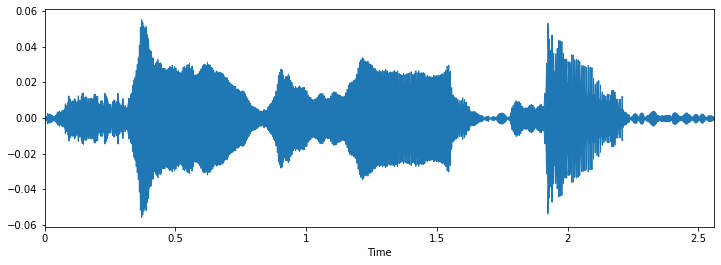

In [6]:
data_s, sampling_rate_s = librosa.load(sad_file)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data_s, sr=sampling_rate_s)

In [7]:
ipd.Audio(happy_file)

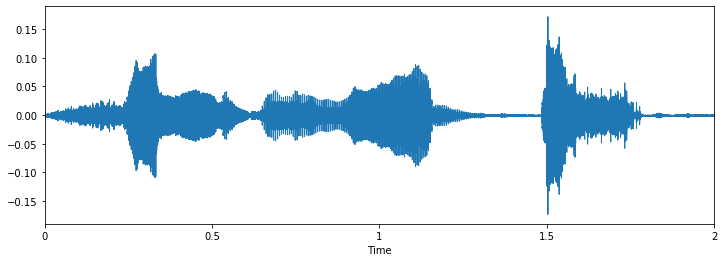

In [8]:
data_h, sampling_rate_h = librosa.load(happy_file)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data_h, sr=sampling_rate_h)

## Create metadata of audio files used for training and evaluation

Labels in the analysed dataset name emotions. Having heared multiple audio files, it became clear that a human would misclassify some of them. This happens because labels depend on interpretation of the speaker and overall, emotions labelling is difficult for people, let alone doing it from the voice.

In [4]:
def create_metadata(src_dir):
    """Discover all wav files in a directory and parse files names to create a dataframe with files metadata 
    
    Args:
        src_dir: source directory
    
    Return:
        files_df: dataframe with filename, file id, speaker (), pronouced word, emotion class.
    """
    import os
    file_dict = dict()
    ## partially sourced from https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
    for idx, file in enumerate(os.listdir(src_dir)):
        if file.endswith(".wav"):
            file_dict[idx] = file      
        
    files_df = pd.DataFrame.from_dict(file_dict, orient='index', columns = ['filename'])
    files_df['file_id'] = files_df.index
    files_df['speaker'], files_df['word'], files_df['label']  = files_df['filename'].str.split('_').str
    files_df['label'] = files_df['label'].str.replace('.wav', '') 
    
    return files_df
    

In [5]:
files_metadata_df = create_metadata('data/')

In [6]:
#select classes for training
classes_select = ['sad', 'happy', 'angry', 'fear', 'neutral']

files_select = files_metadata_df.loc[files_metadata_df['label'].isin(classes_select)]

In [7]:
files_select.head()

,filename,file_id,speaker,word,label
1,OAF_back_angry.wav,1,OAF,back,angry
3,OAF_back_fear.wav,3,OAF,back,fear
4,OAF_back_happy.wav,4,OAF,back,happy
5,OAF_back_neutral.wav,5,OAF,back,neutral
7,OAF_back_sad.wav,7,OAF,back,sad


## Feature engineering

Audio files are loadeded and a Mel-frequency cepstral coefficients is extracted.

In [8]:
#sourced from https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/
def parser_train(row):
    # function to load files and extract features
    file_name = os.path.join('data/', row.filename)
    
    # handle exception to check if there isn't a file which is corrupted
    try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None
    
    return mfccs

In [9]:
files_select['mfccs'] = files_select.apply(parser_train, axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
files_select.head(1)

,filename,file_id,speaker,word,label,mfccs
1,OAF_back_angry.wav,1,OAF,back,angry,"[-387.26328, 58.097065, -23.014156, -6.43627, ..."


## Modelling
* create test and train sets
* transorm train inputs to appropriate formats
* create and train a model
* predict emotion labels on the test data 
* calculate accuracy and confusion matrix

An AWS article about deployment of keras models assumes usage of TensorFlow and therefore the model was trained with it.

In [11]:
X = files_select['mfccs']
y = files_select['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
print("Items in train set: {}".format(len(y_train)))
print("Items in test set: {}".format(len(y_test)))

Items in train set: 1339
Items in test set: 660


In [13]:
#Convert the data to pass it in our deep learning model
X = np.array(X_train.tolist())
y = np.array(y_train.tolist())

In [14]:
# transform labels to numeric categories
# TODO save mapping dictionary
lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(y))

In [41]:
num_labels = y.shape[1]
filter_size = 2

# adapted from https://www.tensorflow.org/tutorials/keras/save_and_load
def create_model():
    model = tf.keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(40,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_labels, activation='softmax')
  ])
    
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [61]:
# Create a basic model instance
model_tf = create_model()

# Display the model's architecture
model_tf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               10496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 77,573
Trainable params: 77,573
Non-trainable params: 0
_________________________________________________________________


In [63]:
model_tf.fit(X, y, batch_size=32, epochs=5)

Train on 1339 samples
Epoch 1/5
1339/1339 [==============================] - 0s 342us/sample - loss: 23.4530 - accuracy: 0.2980
Epoch 2/5
1339/1339 [==============================] - 0s 59us/sample - loss: 6.6544 - accuracy: 0.4668
Epoch 3/5
1339/1339 [==============================] - 0s 59us/sample - loss: 2.8820 - accuracy: 0.5691
Epoch 4/5
1339/1339 [==============================] - 0s 59us/sample - loss: 1.6558 - accuracy: 0.6647
Epoch 5/5
1339/1339 [==============================] - 0s 59us/sample - loss: 1.1163 - accuracy: 0.7065


In [86]:
# name directories as described in https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/
# changed 
directory = 'export'
if not os.path.exists(directory):
    os.makedirs(directory)

# sourced from https://www.tensorflow.org/tutorials/keras/save_and_load
# Save the entire model as a SavedModel
model_tf.save('export/1') 

INFO:tensorflow:Assets written to: export/1/assets


In [87]:
!ls export/1

assets         saved_model.pb variables


In [88]:
#verify saved model by loading
new_model = tf.keras.models.load_model('export/1')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               10496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 77,573
Trainable params: 77,573
Non-trainable params: 0
_________________________________________________________________


### Predict

In [69]:
# transorm test inputs to appropriate format
X_test = np.array(X_test.tolist())

In [70]:
# predict numeric labels and convert them back to categorical labels
y_preds = model_tf.predict_classes(X_test)
y_preds_labels = list(lb.inverse_transform(y_preds))

In [71]:
# adapted from https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.crosstab.html
y_test_cat = pd.Categorical(y_test, categories=classes_select)
y_preds_labels_cat = pd.Categorical(y_preds_labels, categories=classes_select)
pd.crosstab(y_test_cat, y_preds_labels_cat)

col_0,sad,happy,angry,fear,neutral
row_0,,,,,
sad,142,0,0,0,0
happy,0,97,18,11,0
angry,1,2,130,6,0
fear,0,0,0,126,0
neutral,8,0,0,0,119


In [72]:
acc_test = metrics.accuracy_score(y_test, y_preds_labels)
print("Accuracy on the train set: {}".format(acc_test))

Accuracy on the train set: 0.9303030303030303


## Test with self-recorded file

In [73]:
def predict_from_file(wav_file):
    """Predict emotion label from file.
    Args:
       wav_file: name of a .wav audio file 
    Returns:
        y_pred_label: categorical emotion label
    """
    X, sample_rate = librosa.load(wav_file) 
    # extract mfcc feature from data
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    # predict numeric label and convert to categorical label
    y_pred = model.predict_classes(mfccs.reshape(1,40))
    y_pred_label = list(lb.inverse_transform(y_pred))
    
    return y_pred_label

In [74]:
predict_from_file('self_recorded/AC_city_neutral.wav')

['happy']

In [75]:
# predict categories from self-recorded files
src_dir = 'self_recorded/'
for file in os.listdir(src_dir):
    if file.endswith(".wav"):
        file_name = os.path.join(src_dir, file)
        pred = predict_from_file(file_name)
        print("File {} - prediction: {}".format(file, pred[0]))

File AC_city_happy.wav - prediction: happy
File AC_city_neutral.wav - prediction: happy
File AC_city_sad.wav - prediction: sad


### Save test and train files

In [77]:
# function sourced from Plagiarism Detection project from the Udacity ML Engineer Nanodegree
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    # your code here
    df = pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
    df.to_csv(os.path.join(data_dir, filename), index=False, header=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [78]:
data_dir = 'modelling'
make_csv(X_train, y_train, filename='train.csv', data_dir=data_dir)
make_csv(X_test, y_test, filename='test.csv', data_dir=data_dir)

Path created: modelling/train.csv
Path created: modelling/test.csv
